In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot,  Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from wordcloud import WordCloud
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!pip install wordcloud

  Using cached wordcloud-1.9.4-cp312-cp312-win_amd64.whl.metadata (3.5 kB)
  Using cached pillow-11.1.0-cp312-cp312-win_amd64.whl.metadata (9.3 kB)
  Using cached matplotlib-3.10.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp312-cp312-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.55.3-cp312-cp312-win_amd64.whl.metadata (168 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
Using cached wordcloud-1.9.4-cp312-cp312-win_amd64.whl (301 kB)
Using cached matplotlib-3.10.0-cp312-cp312-win_amd64.whl (8.0 MB)
Using cached pillow-11.1.0-cp312-cp312-win_amd64.whl (2.6 MB)
Using cached contourpy-1.3.1-cp312-cp312-win_amd64.whl (220 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.55.3-cp312-cp312-win_amd64.whl (2.2 MB)
Using cached kiwisolver-1.4.8-cp312-cp312-win


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### READING ANIMELIST.CSV DATA


In [49]:
import os

In [50]:
INPUT_DIR = os.path.join('..', 'artifacts', 'raw')

In [51]:
rating_df = pd.read_csv(INPUT_DIR + '/animelist.csv', low_memory=True,usecols=["user_id", "anime_id", "rating"])
rating_df.head(4)

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0


In [52]:
len(rating_df)

5000000

##### Lets talk about columns:
1. user_id : unique id given to each user
2. anime_id : unique id given to each anime
3. rating :score given to that anime by a particular user from 0 to 10

### DATA PROCESSING

This code filters out users with fewer than 400 ratings to focus on "active" users who have rated many anime. It reduces noise in the dataset by excluding infrequent users, which is often useful in recommendation systems or analysis.

In [53]:
n_ratings = rating_df['user_id'].value_counts()
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings >= 400].index)].copy()
len(rating_df)

3246641

Finds the minimum value in the rating column of the rating_df dataframe.
Finds the maximum value in the rating column.
Calculates the average (mean) of the rating column.
Applies min-max scaling to normalize the rating values between 0 and 1.0.

Scaling ratings is important in machine learning tasks like clustering, similarity calculations, or recommendation systems to bring all features to a comparable range.

Recalculates the average of the rating column after normalization.

The original scale (1-10) is compressed into a 0-1 range.
Relationships in data is still preserved

In [54]:
# Scaling BTW (0 , 1.0)
min_rating = min(rating_df['rating'])
max_rating = max(rating_df['rating'])
avg_rating = np.mean(rating_df['rating'])
rating_df['rating'] = rating_df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

AvgRating = np.mean(rating_df['rating'])

In [55]:
print('Max', max_rating)
print('Min', min_rating)
print('Avg - before scaled', avg_rating)
print('Avg - after scaled', AvgRating)

Max 10
Min 0
Avg - before scaled 4.122732695114736
Avg - after scaled 0.4122732695114729


In [56]:
#### Removing duplicates

rating_df.duplicated().sum()

np.int64(0)

- Extracting unique user IDs from the data.
- Mapping each user ID to a unique number (encoding) to convert the user IDs into integers.
- Adding this encoding as a new column in the DataFrame.
- Counting the total number of unique users.

In [57]:
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user2user_decoded = {i: x for i, x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)
n_users = len(user2user_encoded)

In [58]:
n_users               ### We have this much unique users

4203

Doing same as we did for users ....

- Extracting unique anime IDs from the data.
- Mapping each anime ID to a unique number (encoding) to convert the anime IDs into integers.
- Adding this encoding as a new column in the DataFrame.
- Counting the total number of unique anime IDs.

In [59]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime2anime_decoded = {i: x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)
n_animes = len(anime2anime_encoded)

In [60]:
n_animes                     ## We have this much animes

17149

- Shuffling our entire dataset and also dropping previous indexes and giving new indexes
-- Why shuffling ?
* Generates randomness in data
* Prevents data leakage

- Splitting into input and output columns for our model

In [61]:
rating_df = rating_df.sample(frac=1, random_state=73).reset_index(drop=True)

X = rating_df[['user', 'anime']].values
y = rating_df["rating"]

In [62]:
#### Splitting into training and testing set

test_set_size = 1000
train_indices = rating_df.shape[0] - test_set_size 

X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [63]:
len(X_train)     ## Training data


3245641

In [64]:
len(X_test)     ## Test data


1000

In [65]:
type(X_train)

numpy.ndarray

- The code is splitting the X_train and X_test arrays into separate arrays for the user and anime features.
- After that, it stores these arrays in lists (X_train_array and X_test_array), so you'll have two separate lists for training and testing data: 
- one for users and one for anime.

In [66]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [67]:
type(X_train_array)     #Converted to list that contains two arrays

list

### MODEL ARCHITECTURE

In [68]:
def RecommenderNet():
    embedding_size = 128
    
    ### This layer will accept input for user
    user = Input(name = 'user', shape = [1])

    ### This creates the embedding layer for the user, mapping each user ID to a 128-dimensional vector.
    ### Embedding layer converts data into vectors...
    user_embedding = Embedding(name = 'user_embedding',
                       input_dim = n_users, 
                       output_dim = embedding_size)(user)
    
    ### This layer will accept input for anime
    anime = Input(name = 'anime', shape = [1])

    ### This creates the embedding layer for the anime, mapping each anime ID to a 128-dimensional vector.
    anime_embedding = Embedding(name = 'anime_embedding',
                       input_dim = n_animes, 
                       output_dim = embedding_size)(anime)
    
    ### This calculates the dot product (similarity) between the user and anime embeddings.
    ## The dot product measures how similar the two vectors are. We have to normalize data also..

    x = Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, anime_embedding])

    ## The output of the dot product is reshaped into a one-dimensional array
    x = Flatten()(x)
        
    ## This is a fully connected (dense) layer that outputs a single value
    ## This layer normalizes the output from the previous layer
    ## This applies the sigmoid activation function, which outputs a value between 0 and 1
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    

    ### Make and compile the model and return it 
    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer='Adam')
    
    return model

In [69]:
### Initialize the model

model = RecommenderNet()

In [70]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          2 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

-  Callbacks are functions or actions that are triggered during the training process, such as adjusting the learning rate or saving the model weights


In short here we will list paramters for our model training

In [71]:

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

checkpoint_filepath = './weights.weights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True)

early_stopping = EarlyStopping(patience = 3, monitor='val_loss', 
                               mode='min', restore_best_weights=True)

my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping,   
]

In [72]:
# Model training
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 0.7975 - mae: 0.3815 - mse: 0.1964 - val_loss: 0.7268 - val_mae: 0.3738 - val_mse: 0.1741 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - loss: 0.7945 - mae: 0.3804 - mse: 0.1952 - val_loss: 0.7948 - val_mae: 0.3871 - val_mse: 0.1998 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - loss: 0.7892 - mae: 0.3784 - mse: 0.1930 - val_loss: 0.8018 - val_mae: 0.3883 - val_mse: 0.2020 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.7807 - mae: 0.3750 - mse: 0.1896 - val_loss: 0.7983 - val_mae: 0.3875 - val_mse: 0.2007 - learning_rate: 3.4000e-05


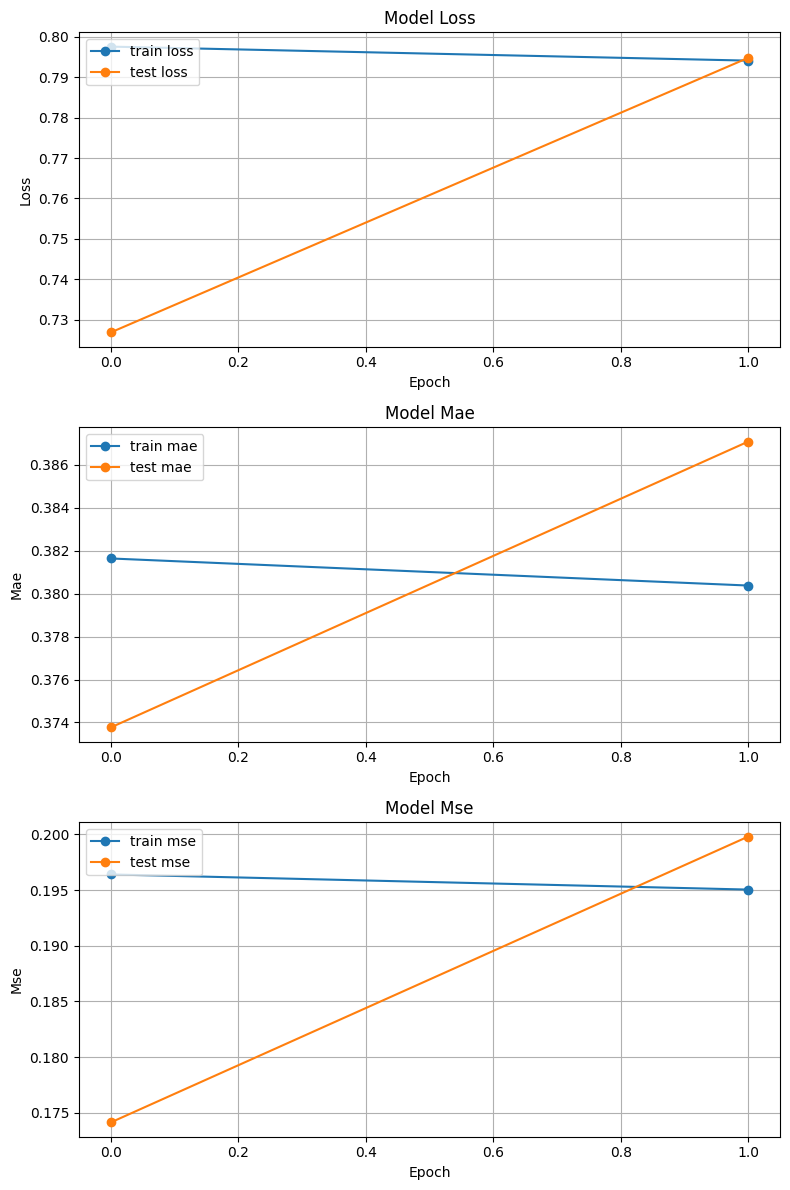

In [73]:
##### Model Training Result Metrics
# List of metrics to plot
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

Extracting the weights (embeddings) from the model helps you to capture the learned representations of users and animes.

In [74]:
### Extract weights fro model
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

anime_weights = extract_weights('anime_embedding', model)
user_weights = extract_weights('user_embedding', model)

### READING ANIME.CSV

In [75]:
df = pd.read_csv(INPUT_DIR + '/anime.csv', low_memory=True)


In [76]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, Magic",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [77]:
df = df.replace("Unknown", np.nan)

- This function help you get a anime name by its id. If its english name is availble good we will use taht otherwise we will use name from NAME column ...

In [78]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print('error')
    
    return name


- Create new columns : anime_id from MAL_ID and eng_version fromm ENG_VERSION and NAME COLUMN

- For each anime ID, it applies the getAnimeName function to fill the eng_version with the English name of the anime. If the English name is not available, it tries to get the name from a different column.

- Sorts the DataFrame by the Score column in descending order, so that higher-scoring animes come first.

- The final DataFrame only contains the following columns


In [79]:
df['anime_id'] = df['MAL_ID']
df["eng_version"] = df['English name']
df['eng_version'] = df.anime_id.apply(lambda x: getAnimeName(x))

df.sort_values(by=['Score'], 
               inplace=True,
               ascending=False, 
               kind='quicksort',
               na_position='last')

df = df[["anime_id", "eng_version", 
         "Score", "Genres", "Episodes", 
         "Type", "Premiered", "Members"]]

- A function that asks for either a integer or string 

- If integer : It searches the DataFrame for the row(s) where the anime_id matches the input integer and returns those rows.

- If string : It searches the DataFrame for the row(s) where the eng_version (English name) matches the input string and returns those rows.

In [80]:
def getAnimeFrame(anime , df):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]

In [81]:
getAnimeFrame(1 , df)


,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26,TV,Spring 1998,1251960


In [82]:
getAnimeFrame("Naruto",df)


,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
10,20,Naruto,7.91,"Action, Adventure, Comedy, Super Power, Martial Arts, Shounen",220,TV,Fall 2002,1830540


### READING ANIME_WITH_SYNOPSIS.CSV

- Just like we did above instead of anime name and all it will fetch us synopsis

In [83]:
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]
sypnopsis_df = pd.read_csv(INPUT_DIR + '/anime_with_synopsis.csv', usecols=cols)


In [84]:
def getSypnopsis(anime,sypnopsis_df):
    if isinstance(anime, int):
        return sypnopsis_df[sypnopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime, str):
        return sypnopsis_df[sypnopsis_df.Name == anime].sypnopsis.values[0]

In [85]:
getSypnopsis(1,sypnopsis_df)


'In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as "Cowboys." The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member\'s dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic an

In [86]:
getSypnopsis("Naruto",sypnopsis_df)


"oments prior to Naruto Uzumaki's birth, a huge demon known as the Kyuubi, the Nine-Tailed Fox, attacked Konohagakure, the Hidden Leaf Village, and wreaked havoc. In order to put an end to the Kyuubi's rampage, the leader of the village, the Fourth Hokage, sacrificed his life and sealed the monstrous beast inside the newborn Naruto. Now, Naruto is a hyperactive and knuckle-headed ninja still living in Konohagakure. Shunned because of the Kyuubi inside him, Naruto struggles to find his place in the village, while his burning desire to become the Hokage of Konohagakure leads him not only to some great new friends, but also some deadly foes."

## ITEM BASED RECOMMNDATION

In [87]:
pd.set_option("max_colwidth", None)


def find_similar_animes(name, anime_weights , anime2anime_encoded , anime2anime_decoded, df , synopsis_df , n=10, return_dist=False, neg=False):
    try:
        index = getAnimeFrame(name,df).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)

        weights = anime_weights
        
        
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
       
        n = n + 1            
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('Animes closest to {}'.format(name))


        
        if return_dist:
            return dists, closest
        
        
        SimilarityArr = []

        for close in closest:

            
            decoded_id = anime2anime_decoded.get(close)

            
            sypnopsis = getSypnopsis(decoded_id,synopsis_df)

            
            anime_frame = getAnimeFrame(decoded_id,df)
            
            
            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]
            SimilarityArr.append({"anime_id": decoded_id, "name": anime_name,
                                  "similarity": similarity,"genre": genre,
                                  'sypnopsis': sypnopsis})

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)

    except:
        print('{}!, Not Found in Anime list'.format(name))

In [88]:
find_similar_animes('Dragon Ball Z', anime_weights,anime2anime_encoded,anime2anime_decoded,df,sypnopsis_df, n=5, neg=False)

Animes closest to Dragon Ball Z


,name,similarity,genre,sypnopsis
4,Mikan Seijin Arawaru,0.353515,Comedy,"The story centers on the titular Mikan Seijin (Orange Alien), who appears from Local 3 (an orange planet in a higher dimension) with plans of invading the Earth. (Source: ANN)"
3,Sore Ike! Anpanman: Rhythm de Teasobi - Anpanman to Fushigi na Parasol,0.345641,"Comedy, Kids, Fantasy",No synopsis information has been added to this title. Help improve our database by adding a synopsis here .
2,Kurumiwari Ningyou (2014),0.341139,"Fantasy, Romance, Drama",2014 adaptation of the original Nutcracker story by E.T.A. Hoffmann.
1,Drifters (OVA): Kokuou-sama Goranshin,0.334652,"Comedy, Parody",Final episode of Kokuou-sama Goranshin released with the new Drifters episodes 13-14 Blu-ray disc.
0,Diseases Spread,0.317976,Kids,"Eating a fish of frying, making flies in food due to improper circumstances, doing washing in the river, etc, the terrible venom spreads unexpectedly. In order to prevent it, it is essential to disinfect with salad water. When going out, it is important to mask the fungus and prevent fungal invasion and disinfect futon etc in the sunlight. Since one person's carelessness will lead to the family and, in the end, the disease spread will spread out in Japan, urge the attention so that hygiene ideals will spread. (Source: Japanese Animated Film Classics)"


In [89]:
find_similar_animes('Black Clover',anime_weights,anime2anime_encoded,anime2anime_decoded,df,sypnopsis_df, n=5, neg=False)

Animes closest to Black Clover


,name,similarity,genre,sypnopsis
4,Usavich Zero,0.341919,Comedy,Prequel to the first Usavich season.
3,Duel Masters Victory V3,0.329382,"Action, Adventure, Comedy, Shounen",In this series the story continues after Katta Kirifuda defeats the YA.RA.SI band and also gains back his popularity by defeating Leo and his sidekick Nai Minamimo. In this series Katta will use a new race of Outrage creatures against the opposing new race of Oracle deck users. Also in the creature world a new time era will start off. (Source: Duel Masters Wikia)
2,Yowamushi Pedal: New Generation,0.326288,"Comedy, Sports, Drama, Shounen","Third season of the Yowamushi Pedal series. With the team's combined strength, the Sohoku High bicycle racing club beat reigning champions Hakone Academy at the Interhigh national race and achieved an impressive overall victory. Now that their hot summer has ended and third-years Kinjou, Makishima, and Tadokoro have retired from the team, first-year participants in the Interhigh Onoda Sakamichi, Imaizumi Shunsuke, and Naruko Shoukichi, along with their new captain second-year Teshima Junta and vice-captain Aoyagi Hajime begin preparing as a ""new team"" for their second consecutive championship at the next Interhigh. In order to retake their throne, their rivals Hakone Academy have also incorporated new members and begun training as a new team. Kyoto Fushimi High is lead by the monstrous racer Midousuji Akira. The nation's top schools are all honing their skills to reach the top of the Interhigh. (Source: Crunchyroll)"
1,Queen's Blade: Rebellion,0.319905,"Action, Adventure, Ecchi, Fantasy","Power corrupts, and it when it appears that the once noble Queen Claudette's ways have turned to oppression and heretical persecution, it's up to a new generation of warriors to step up to the plate armor to bear arms and bare their naked fury in open rebellion! The odds may seem unfairly stacked in favor of the Amazonian ranks of the queen, doubly supported by her power of writ and assassins. But the incredible wits and assets of the dazzling array of daring damsels willing to risk their gorgeous skins and put their lithesome bodies on line against her, might just expose a few unexpected weaknesses in the queen's support! (Source: Sentai Filmworks)"
0,Natsu-iro Kiseki: 15-kaime no Natsuyasumi,0.305900,Slice of Life,"seven minute epilogue to the TV series, released as an OVA."


### USER BASED RECOMMENDATION

- Picking a random use who has not watched much anime so that we can give him recommendation based on what other people watch

In [90]:
ratings_per_user = rating_df.groupby('user_id').size()
random_user = ratings_per_user[ratings_per_user < 500].sample(1, random_state=None).index[0]
print('> user_id:', random_user)

> user_id: 15829


In [91]:
pd.set_option("max_colwidth", None)

def find_similar_users(item_input, user_weights , user2user_encoded , user2user_decoded, n=10,return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user2user_encoded.get(index)
        weights = user_weights
    
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n + 1
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('> users similar to #{}'.format(item_input))

        if return_dist:
            return dists, closest
        
        SimilarityArr = []
        
        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({"similar_users": decoded_id, 
                                      "similarity": similarity})

        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity", 
                                                        ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        
        return similar_users
    
    except:
        print('{}!, Not Found in User list'.format(item_input))

In [93]:
find_similar_users(int(random_user), user_weights,user2user_encoded,user2user_decoded,
                                   n=5, 
                                   neg=False)

> users similar to #15829


,similar_users,similarity
4,5321,0.315259
3,12347,0.298093
2,14527,0.281621
1,13027,0.275331
0,10497,0.274554


- You will se the user itself alsois included in list . We should avoid this

In [94]:
similar_users = find_similar_users(int(random_user), user_weights,user2user_encoded,user2user_decoded,
                                   n=5, 
                                   neg=False)

similar_users = similar_users[similar_users.similar_users != random_user]
similar_users.head(5)

> users similar to #15829


,similar_users,similarity
4,5321,0.315259
3,12347,0.298093
2,14527,0.281621
1,13027,0.275331
0,10497,0.274554


- We have low similarity scores as we trained our model on just 5M rows but it originally has 7 crore rows

It extracts genres from the Genres column, counts their occurrences, and returns a list of all genres.

In [95]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, 
                             background_color='white', 
                             colormap='gnuplot').generate_from_frequencies(all_genres)
    
    plt.figure(figsize=(10,8)) 
    plt.imshow(genres_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def getFavGenre(frame, plot=False):
        frame.dropna(inplace=False)
        all_genres = defaultdict(int)
        
        genres_list = []
        for genres in frame['Genres']:
            if isinstance(genres, str):
                for genre in genres.split(','):
                    genres_list.append(genre)
                    all_genres[genre.strip()] += 1    
        if plot:
            showWordCloud(all_genres)
        
        return genres_list

In [97]:
def get_user_preferences(user_id, rating_df , df , verbose=0 , plot=False):

    ## retrieves all anime that the user has rated.
    animes_watched_by_user = rating_df[rating_df.user_id==user_id]

    ## This means it finds the rating value that is higher than 75% of the ratings given by the user.
    ## Basically it is finding top ratings by user...
    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)

    ## Filters out all ratings below the 75th percentile, keeping only the user's highest-rated anime.
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    ## Sorts the user's top-rated anime in descending order of ratings.
    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False)#.head(10)
        .anime_id.values
    )
    
    ## Extract only those highly rated anime from main dataframe
    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]
    
    if verbose != 0:
        print("> User #{} has rated {} movies (avg. rating = {:.1f})".format(
          user_id, len(animes_watched_by_user),
          animes_watched_by_user['rating'].mean(),
        ))
    if plot:
        getFavGenre(anime_df_rows, plot)
                
    return anime_df_rows

> User #15829 has rated 112 movies (avg. rating = 0.7)


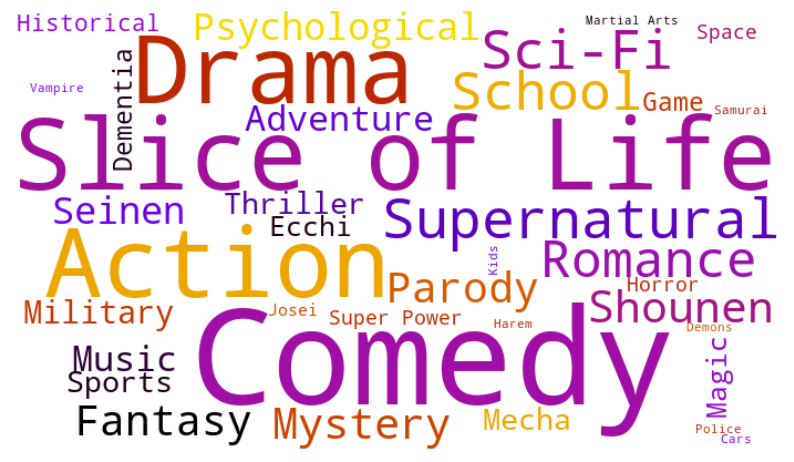

> animes highly rated by this user


In [98]:
user_pref = get_user_preferences(random_user, rating_df, df, plot=True ,verbose=1)
print('> animes highly rated by this user')


In [99]:
pd.DataFrame(user_pref).head(5)

,eng_version,Genres
5683,Steins;Gate,"Thriller, Sci-Fi"
11308,Your Name.,"Romance, Supernatural, School, Drama"
176,Spirited Away,"Adventure, Supernatural, Drama"
239,Fighting Spirit,"Comedy, Sports, Drama, Shounen"
4970,The Disappearance of Haruhi Suzumiya,"Comedy, Mystery, Romance, School, Sci-Fi, Supernatural"


## Recommending anime for user ( USER-BASED )

In [100]:
def get_top_recommended_animes(similar_users, user_pref, df, synopsis_df, rating_df, n=10):
    recommended_animes = []
    anime_list = []

    ## Loop through Similar Users
    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id), rating_df, df, verbose=0)

        # Filter out animes already rated by the current user
        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
        anime_list = pd.DataFrame(anime_list)
        
        # Get the top n recommended animes
        sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

        for i, anime_name in enumerate(sorted_list.index):
            n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]
            if isinstance(anime_name, str):
                try:
                    frame = getAnimeFrame(anime_name, df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    sypnopsis = getSypnopsis(int(anime_id), synopsis_df)
                    recommended_animes.append({
                        "n": n_user_pref,
                        "anime_name": anime_name,
                        "Genres": genre,
                        "sypnopsis": sypnopsis
                    })
                except Exception as e:
                    print(f"Error fetching details for {anime_name}: {e}")

    return pd.DataFrame(recommended_animes).head(n)  # Only return the top n recommendations


In [101]:
user_recs = get_top_recommended_animes(similar_users,user_pref,df,sypnopsis_df,rating_df, n=10)
getFavGenre(user_recs, plot=False)

print('\n> Top recommendations for user: {}'.format(random_user))
user_recs


> Top recommendations for user: 15829


,n,anime_name,Genres,sypnopsis
0,5,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power","Hunter x Hunter is set in a world where Hunters exist to perform all manner of dangerous tasks like capturing criminals and bravely searching for lost treasures in uncharted territories. Twelve-year-old Gon Freecss is determined to become the best Hunter possible in hopes of finding his father, who was a Hunter himself and had long ago abandoned his young son. However, Gon soon realizes the path to achieving his goals is far more challenging than he could have ever imagined. Along the way to becoming an official Hunter, Gon befriends the lively doctor-in-training Leorio, vengeful Kurapika, and rebellious ex-assassin Killua. To attain their own goals and desires, together the four of them take the Hunter Exam, notorious for its low success rate and high probability of death. Throughout their journey, Gon and his friends embark on an adventure that puts them through many hardships and struggles. They will meet a plethora of monsters, creatures, and characters—all while learning what being a Hunter truly means."
1,4,Bakuman.,"Comedy, Drama, Romance, Shounen","Onto their third serialization, manga duo Moritaka Mashiro and Akito Takagi—also known by their pen name, Muto Ashirogi—are ever closer to their dream of an anime adaption. However, the real challenge is only just beginning: if they are unable to compete with the artist Eiji Niizuma in the rankings within the span of six months, they will be canceled. To top it off, numerous rivals are close behind and declaring war. They don't even have enough time to spare thinking about an anime! In Bakuman. 3rd Season , Muto Ashirogi must find a way to stay atop the colossal mountain known as the Shounen Jack rankings. With new problems and new assistants, the pair continue to strive for their dream."
2,4,Golden Time,"Comedy, Drama, Romance","Due to a tragic accident, Banri Tada is struck with amnesia, dissolving the memories of his hometown and past. However, after befriending Mitsuo Yanagisawa, he decides to move on and begin a new life at law school in Tokyo. But just as he is beginning to adjust to his college life, the beautiful Kouko Kaga dramatically barges into Banri's life, and their chance meeting marks the beginning of an unforgettable year. After having a glimpse of college life, Banri learns that he is in a new place and a new world—a place where he can be reborn, to have new friends, fall in love, makes mistakes and grow. And as he begins to discover who he was, the path he has chosen leads him towards a blindingly bright life that he will never want to forget."
3,4,Tokyo Ghoul,"Action, Mystery, Horror, Psychological, Supernatural, Drama, Seinen","Tokyo has become a cruel and merciless city—a place where vicious creatures called ""ghouls"" exist alongside humans. The citizens of this once great metropolis live in constant fear of these bloodthirsty savages and their thirst for human flesh. However, the greatest threat these ghouls pose is their dangerous ability to masquerade as humans and blend in with society. Based on the best-selling supernatural horror manga by Sui Ishida, Tokyo Ghoul follows Ken Kaneki, a shy, bookish college student, who is instantly drawn to Rize Kamishiro, an avid reader like himself. However, Rize is not exactly who she seems, and this unfortunate meeting pushes Kaneki into the dark depths of the ghouls' inhuman world. In a twist of fate, Kaneki is saved by the enigmatic waitress Touka Kirishima, and thus begins his new, secret life as a half-ghoul/half-human who must find a way to integrate into both societies."
4,4,"Love, Chunibyo & Other Delusions!","Slice of Life, Comedy, Drama, Romance, School","Everybody has had that stage in their life where they have thought themselves to be special, different from the masses of ordinary humans. They might go as far as seeing themselves capable of wielding mystical powers, or maybe even believe themselves

# FINAL RECOMMENDER ( HYBRID )

In [ ]:
def hybrid_recommendation(user_id, user_weight=0.6, content_weight=0.4):
    # Step 1: User-Based Recommendation
    similar_users = find_similar_users(user_id, user_weights, user2user_encoded, user2user_decoded, n=5, neg=False)
    user_pref = get_user_preferences(user_id, rating_df, df)
    user_recommended_animes = get_top_recommended_animes(similar_users, user_pref, df, sypnopsis_df, rating_df, n=10)
    
    # Extract user-recommended anime names
    user_recommended_animes_list = user_recommended_animes['anime_name'].tolist()
    
    # Step 2: Content-Based Recommendation
    content_recommended_animes = []
    for anime in user_recommended_animes_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, sypnopsis_df, n=5, neg=False)
        if similar_animes is not None and not similar_animes.empty:  # Check if the result is valid
            content_recommended_animes.extend(similar_animes['name'].tolist())  # Adjust column name as needed
        else:
            print(f"No similar animes found for: {anime}")
    
    # Step 3: Combine Recommendations with Weights
    combined_scores = {}
    
    # Add user-based recommendations with weights
    for anime in user_recommended_animes_list:
        combined_scores[anime] = combined_scores.get(anime, 0) + user_weight
    
    # Add content-based recommendations with weights
    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime, 0) + content_weight
    
    # Sort by combined score in descending order
    sorted_animes = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Return top N recommendations
    return [anime for anime, score in sorted_animes[:10]]

Showing hybrid recommendations for user: 16105
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
---------------------------------------------------------------------------
> Top 10 hybrid anime recommendations
---------------------------------------------------------------------------


,name,final_score,genre,sypnopsis
0,Super Zugan,0.337129,"Game, Comedy, Shounen",story about mahjong.
1,Peaceful Times (F02) Petit Film,0.335174,Music,"The short features previously unseen Evangelion storyboard art. Evangelion director Hideaki Anno supervised the ""petit film,"" and Mahiro Maeda directed and storyboarded it. Shiro Sagisu provided the music, and voice actress Megumi Hayashibara narrates the Japanese version of the English lyrics. Sagisu made a few comments about the video on his website and posted the Japanese version of the lyrics. According to Sagisu, when they were finishing work on Q, Anno told him this would be the last time they used the F2 (Next Episode) theme, which made Sagisu want to make a extended version of it. He says the video actually contains four versions of the song: An unreleased version by the London Studio Orchestra (at the start), the Takahashi version from Xpressions, the version from Piano Forte #1, and Hayashibara’s narrated version. (Source: AniDB)"
2,Flash & Dash 2,0.333808,"Cars, Kids",The second season of Lei Su Deng Shandian Chong Xian .
3,Genbanojou,0.332437,NaN,"In a cone-shaped land named Kikyougahara in Shin Province, there lives a girl named Hana. She is a gentle girl, who always thinks of her family, in particular her great-grandmother Chiyo, whom she affectionately calls ""Granny."" One day, a traveling entertainment troupe named the Natsugawa Genzaemon Troupe happens by, and the villagers welcome them warmly. Upon finishing their performance and receiving their acclaim, the troupe's leader spots Hana with some ""oyaki,"" his favorite food, and transforms into a fox in his excitement. It turns out that the leader Genbanojou, and his companions O-Natsu and Shinzaemon, are all foxes who have taken on human forms. Genbanojou hastily negotiates with Hana, telling her that in exchange for keeping their secret, he will grant her one wish. She answers, ""I want to let my Granny see the cherry blossoms."" (Source: ANN)"
4,Fighting Spirit:Champion Road,0.331361,"Comedy, Shounen, Sports","The challenger has become the champion as Ippo Makunouchi now wears the featherweight championship belt of Japan. Some time has passed since Ippo's victory, and he has found his friends and coach as supportive as ever; his crush, Kumi Mashiba, seems to enjoy spending time with him as well. Things are looking bright for the new champion, but just as he once set his sights on becoming the best, his first challenger poses an intimidating threat. Kazuki Sanada works as a doctor at the same hospital as Kumi and fights strategically. Known for integrating his knowledge of the human body into his fights, Sanada is a fearsome contender—however, more unnerving than his physical ability, he has garnered the support of the nurses. Despite being the champion, Ippo feels the pressure as he must face the daunting challenge, retain his belt, and win over the girl he loves."
5,Peng Ran Xindong,0.329981,"Slice of Life, Romance, Shoujo","Young boys and girls live under one roof and experience the ignorance and troubles of youth. The super-popular girl who is warm in style feels the bud of youthfulness, this one is enough! (Source: Yualexius)"
6,Ghost in the Shell:Ghost Chaser,0.328735,"Action, Sci-Fi, Police, Seinen","de-like VR attraction. The ride will debut at the ""hexaRide"" attraction area of the renewed Diver City Tokyo Plaza. The ride attraction allows up to 12 people to ride at the same time using Q-Ride equipment with six-directional movement, and VR headsets. The ride costs 1,000 yen (about US$9) per person. This story is set in the Kuzan Republic. The defense minister, who will take part in a meeting of the Next-generation Weapon Coordination Council, has ordered an advance onsite inspection. Ride participants are tasked with providing escort while securing an inspection route in Public Security Section 9, where Motoko Kusanagi serves as leader. Riders will use the hexaRide vehicle to enter cyberspace and